# Random Features

## Inputs loading

In [40]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime as datetime
import statsmodels.api as sm
from scipy.optimize import minimize

#### Read from the database

In [ ]:
conn = sqlite3.connect('db2023.db')
query = "SELECT * FROM Z_R_matrices"
results = pd.read_sql_query(query, conn)

# Columns to use for ratios
cols_ratios = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
               'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax',
               'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf',
               'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt',
               'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
               'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be',
               'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
               'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn',
               'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale',
               'accrual', 'ptb', 'PEG_trailing', 'divyield']

# Columns for lagged returns
cols_lags = [f'ret_lag_{i}' for i in range(1, 13)]
char_cols = cols_ratios+cols_lags

# Fetch all distinct dates from the table
dates = pd.read_sql_query('SELECT DISTINCT date FROM Z_R_matrices', conn)
dates_list = dates['date'].tolist()
dates_list.sort()

#### Read from the CSV file

In [2]:
# Read the CSV file into a DataFrame
results = pd.read_csv("Z_R_matrices.csv")
# Columns to use for ratios
cols_ratios = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
               'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax',
               'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf',
               'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt',
               'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
               'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be',
               'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
               'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn',
               'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale',
               'accrual', 'ptb', 'PEG_trailing', 'divyield']

# Columns for lagged returns
cols_lags = [f'ret_lag_{i}' for i in range(1, 13)]
char_cols = cols_ratios+cols_lags

# Convert the 'date' column to datetime
results['date'] = pd.to_datetime(results['date'])

# Extract distinct dates from the DataFrame
dates_list = results['date'].drop_duplicates().sort_values().tolist()


#### Read from JKP CSV file

In [96]:
results = pd.read_csv("Z_R_matrices_jkp.csv")

char_cols = ["ret_1_0", "seas_1_1an", "rskew_21d", "coskew_21d", "iskew_ff3_21d", "iskew_capm_21d", "iskew_hxz4_21d", 
            "rmax5_rvol_21d", "beta_dimson_21d", "ret_3_1", "rmax1_21d", "rmax5_21d", "bidaskhl_21d", "ivol_ff3_21d",
            "ivol_capm_21d", "ivol_hxz4_21d", "rvol_21d", "resff3_6_1", "prc_highprc_252d", "ret_6_1", "ret_12_7", 
            "resff3_12_1", "ret_9_1", "zero_trades_21d", "ret_12_1", "seas_1_1na", "niq_su", "niq_at_chg1", "niq_be_chg1",
            "turnover_var_126d", "dolvol_var_126d", "saleq_su", "ocf_at_chg1", 
            "nfna_gr1a", "dsale_drec", 
            "niq_be", "saleq_gr1", "dbnetis_at", "betadown_252d", "mispricing_perf", "taccruals_at", "cowc_gr1a", 
            "taccruals_ni", "fnl_gr1a", "f_score", "col_gr1a", "niq_at", "market_equity", "tax_gr1a", "coa_gr1a", 
            "prc", "at_gr1", "ocf_me", "noa_gr1a", "inv_gr1", "nncoa_gr1a", "mispricing_mgmt", "ncoa_gr1a", "capx_gr1", 
            "ncol_gr1a", "oaccruals_at", "inv_gr1a", "oaccruals_ni", "ni_me", "eq_dur","be_gr1a", 
            "aliq_mat", "ebitda_mev", 
            "netis_at", "sale_gr1", "chcsho_12m", "dgp_dsale", "eqnpo_12m", "sale_emp_gr1", "ocf_at", "lnoa_gr1a", "fcf_me", 
            "sti_gr1a", "be_me", "ppeinv_gr1a", "aliq_at", "zero_trades_126d", "capx_gr2", "turnover_126d", "noa_at", 
            "ivol_capm_252d", "dsale_dsga", "pi_nix", "debt_gr3", "cop_atl1", "cop_at", "eqnpo_me", "bev_mev", "cash_at",
            "qmj_prof", "dolvol_126d", "ami_126d", "emp_gr1", "ni_be", "eqpo_me", "capx_gr3", "lti_gr1a", "eqnetis_at", 
            "qmj_safety", "div12m_me", "sale_me", "at_me","beta_60m", "netdebt_me", "o_score", "sale_gr3", "ival_me",
            "ope_bel1", "ebit_bev", "op_at", "op_atl1", "ope_be", "debt_me", "at_be", "zero_trades_252d", "sale_bev",
            "tangibility", "z_score", "gp_at", "gp_atl1", "ebit_sale", "kz_index","at_turnover", "opex_at", "age"]

# Convert the 'date' column to datetime
results['date'] = pd.to_datetime(results['date'])

# Extract distinct dates from the DataFrame
dates_list = results['date'].drop_duplicates().sort_values().tolist()

## Import functions

In [97]:
from random_features_sdf import *

## Model configuration

In [114]:
# Fix constants
d = len(char_cols) # number of basic characteristics.
T = len(dates_list)            # Length of our dataset.
L = 128 * d                    # Number of random weights (thus factors).

# Regularization parameters
n_gamma = 30
gammas = np.logspace(-10,3,num = n_gamma, base = 10)

# Multipliers for the number of factors
multipliers = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]

# Define the in-sample (IS) size and rolling window size for the analysis
IS_size = 360  # Number of months for the in-sample in our simple split analysis.
               # For example, set it as 419 for the period from Feb-1970 to Jan-2005.

rolling_window_size = 360  # Rolling window size of 30 years for rolling window analysis

# Random weights configuration
weight_type = "unif_B^d"                    # weight type "gaussian", "unif_B^d" or "unif_S^d-1", "t-student", "unif_B^d+bias"
seed = 0                                    # set seed here, only random part of the algorithm are the weights.

# Activation function and factors configuration
activation = "ReLU" # type of activation units to be used to define the factors. "ReLU", "tanh", "sigmoid" or "cos_sin".
normalize = False   # set to true if instruments are to be centered and normalised to have unit 1-norm (on a monthly basis)
winsorize = True

# Path for figures export
path_figures = "./Figures/ReLU uniform B_d JKP/"

## Random weights and factors computation

In [99]:
# Computing Random Weights

W, xi = random_weights(d,L, weight_type,seed)   # compute random weights

In [100]:
# Compute Factors

F = np.zeros((L,T)) # F is the matrix of factors.
for (t,date) in enumerate(dates_list):
    _, _, F_t = compute_X_R_F(results,char_cols,date,W,activation,normalize, winsorize,xi = xi)
    F[:,t] = F_t

## Market returns

In [182]:
# Query the Fama-French dataset from the connected database/csv

#query_ff = "SELECT * FROM Fama_French"
#fama_french = pd.read_sql_query(query_ff, conn)

fama_french = pd.read_csv("Fama_French.csv")

# Convert the market excess return ("mktrf") column to numeric values, coercing errors to NaN
mkt = pd.to_numeric(fama_french["mktrf"], errors='coerce')


# Calculate the Sharpe Ratio for the market from Jan-2005 to Dec-2023
SR_mkt_split = np.mean(mkt[IS_size+1:]) / np.std(mkt[IS_size+1:]) * np.sqrt(12)
print("Sharpe Ratio Market Simple Split:", SR_mkt_split)

# Calculate the Sharpe Ratio for the market over the entire period (from the rolling window size onwards)
SR_mkt_roll = np.mean(mkt[rolling_window_size+1:]) / np.std(mkt[rolling_window_size+1:]) * np.sqrt(12)
print("Sharpe Ratio Market Rolling (Feb-2000 to Dec-2023):", SR_mkt_roll)

# Convert the "dateff" column to datetime format for proper date handling
fama_french["date"] = pd.to_datetime(fama_french["dateff"])

# Convert the risk-free rate ("rf") column to numeric values, coercing errors to NaN
risk_free = pd.to_numeric(fama_french["rf"], errors='coerce')

# Set the index of the risk-free rate/market series to the corresponding dates for easier time series manipulation
risk_free.index = fama_french["date"]
mkt.index = fama_french["date"]
fama_french.index = fama_french["date"]

Sharpe Ratio Market Simple Split: 0.5739113058782362
Sharpe Ratio Market Rolling (Feb-2000 to Dec-2023): 0.5739113058782362


In [266]:
# Query the Fama-French dataset

fama_french = pd.read_csv("fama_french.csv")

# Convert the "dateff" column to datetime format for proper date handling
fama_french["date"] = pd.to_datetime(fama_french["dateff"])
fama_french.drop(columns="dateff",inplace=True)

# Set the index to the corresponding dates for easier time series manipulation
fama_french.index = fama_french["date"]

#Use month-end dates for the fama_french data
fama_french["date"] = fama_french["date"] + pd.offsets.MonthEnd(0)
fama_french.set_index("date", inplace=True,drop=False)
# Create a DataFrame from the dates_list and match it to the Fama-French dates
dates_list_df = pd.DataFrame(dates_list, columns=['date'])
dates_list_df['date'] = pd.to_datetime(dates_list_df['date'])
# Merge the Fama-French data with the dates_list to filter only the matching dates
fama_french = fama_french.merge(dates_list_df, left_index=True, right_on='date', how='inner')
fama_french.set_index("date", inplace=True,drop=False)
fama_french.drop(columns=["date","date_x","date_y"],inplace=True)

In [271]:
# Convert the market excess return ("mktrf") column to numeric values, coercing errors to NaN
mkt = pd.to_numeric(fama_french["mktrf"], errors='coerce')

# Convert the risk-free rate ("rf") column to numeric values, coercing errors to NaN
risk_free = pd.to_numeric(fama_french["rf"], errors='coerce')

# Calculate the Sharpe Ratio for the market from Jan-2005 to Dec-2023
OOS_start = dates_list[IS_size]
SR_mkt_split = np.mean(mkt[mkt.index >= OOS_start]) / np.std(mkt[mkt.index >= OOS_start]) * np.sqrt(12)
print("Sharpe Ratio Market Simple Split:", SR_mkt_split)

OOS_rolling_start = dates_list[rolling_window_size] 
# Calculate the Sharpe Ratio for the market over the entire period (from the rolling window size onwards)
SR_mkt_roll = np.mean(mkt[mkt.index >= OOS_rolling_start]) / np.std(mkt[mkt.index >= OOS_rolling_start]) * np.sqrt(12)
print("Sharpe Ratio Market Rolling:", SR_mkt_roll)

Sharpe Ratio Market Simple Split: 0.531658709410863
Sharpe Ratio Market Rolling: 0.531658709410863


## Simple Split

In [102]:
b_hat_split, R_P_OOS_split, SR_OOS_split, R_P_split_max = simple_split_SDF(F,W,dates_list, IS_size,L,results,char_cols,activation,normalize,gammas,xi)

In [103]:
np.max(SR_OOS_split)

1.3520233621271491

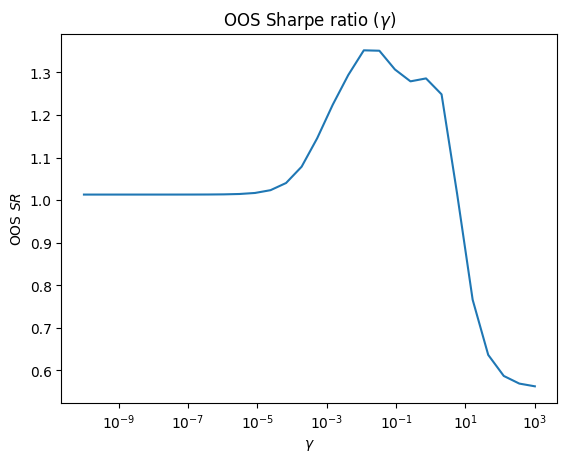

In [115]:
plot_SR(gammas,SR_OOS_split,path_figures + "oos_sr_simple_split_128.png")

In [272]:
# Compute return (excess + risk free) and save it in a Series
index_split_oos = pd.to_datetime(dates_list[IS_size:]) 
R_P_split_max_tot = pd.Series(R_P_split_max, index = index_split_oos) + risk_free[index_split_oos]

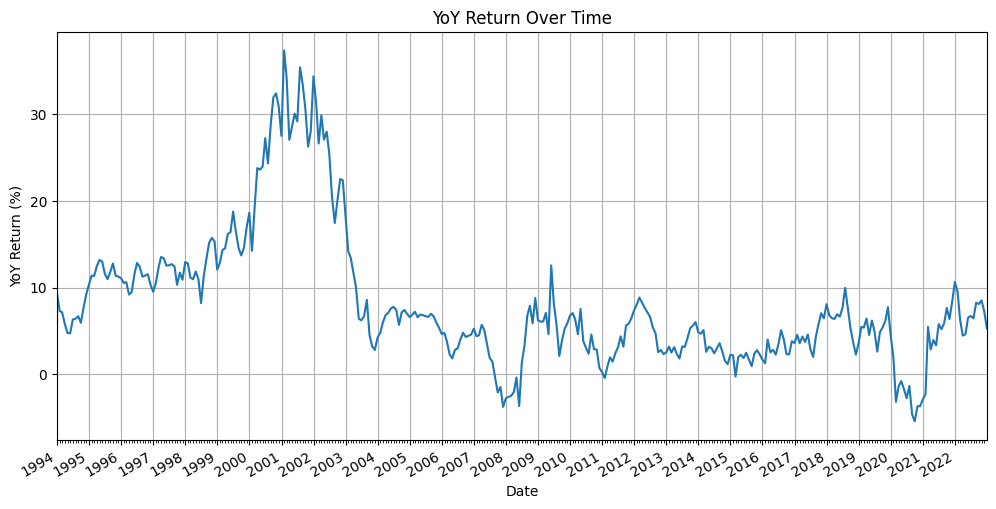

In [273]:
split_yoy_ret = plot_yoy_return_over_time(R_P_split_max_tot,path_figures + "simple_split_128_yoy_ret.png")

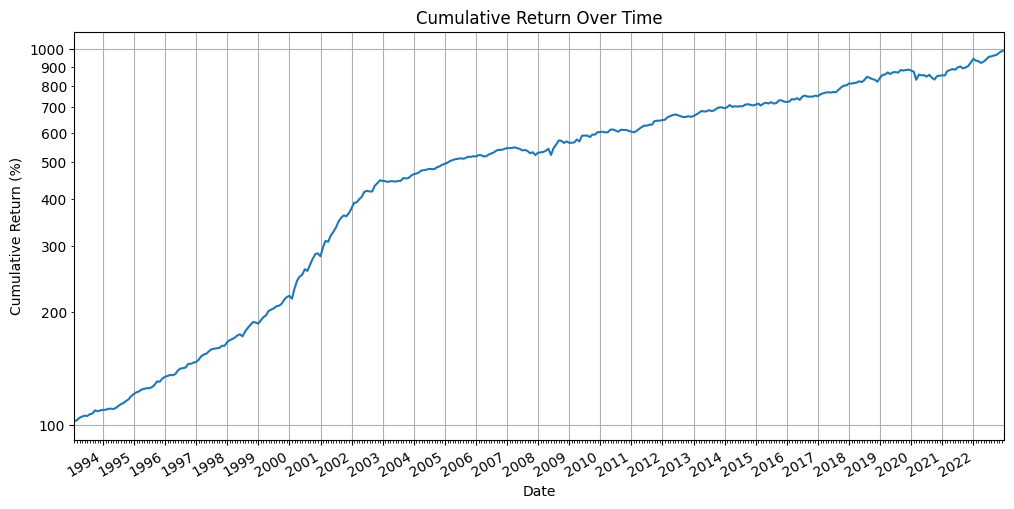

1993-01-31    102.038690
1993-02-28    102.727127
1993-03-31    104.211396
1993-04-30    104.999040
1993-05-31    105.660297
                 ...    
2022-08-31    963.057886
2022-09-30    966.543571
2022-10-31    979.504413
2022-11-30    988.623204
2022-12-31    993.646045
Length: 360, dtype: float64

In [274]:
split_cumulative_ret = plot_cumulative_return(R_P_split_max_tot,path_figures + "simple_split_128_cum_ret.png")
split_cumulative_ret

In [275]:
R_P_split_max_df = pd.Series(R_P_split_max, index = index_split_oos)
res_table_split_capm = calculate_alpha_beta(R_P_split_max_df,mkt,path_figures + "summary_split_capm.csv")

Monthly Alpha: 1.76%
Monthly Alpha standard error: 0.24%
Annualized Alpha: 21.13%
Annualized Alpha standard error: 2.86%
Z-score: 7.3833
Beta: -0.03
Beta standard error: 0.0528
Standard Deviation of Residuals: 4.46%


In [276]:
res_table_split_ff = calculate_fama_french_alpha_beta(R_P_split_max_df,mkt,fama_french, path_figures + "summary_split_ff.csv")

Monthly Alpha: 1.68%
Monthly Alpha SE: 0.25%
Annualized Alpha: 20.13%
Annualized Alpha standard error: 2.99%
Z-score: 6.7324
Betas:
  mktrf: -0.0118
  smb: 0.1148
  hml: -0.0651
  rmw: 0.0749
  cma: 0.1505
Standard Deviation of Residuals: 4.44%


## Rolling Window

In [105]:
R_P_rolling, SR_rolling, R_P_rolling_max = rolling_window_SDF(F, W, dates_list, rolling_window_size, L, results,char_cols, activation, normalize, gammas, xi)

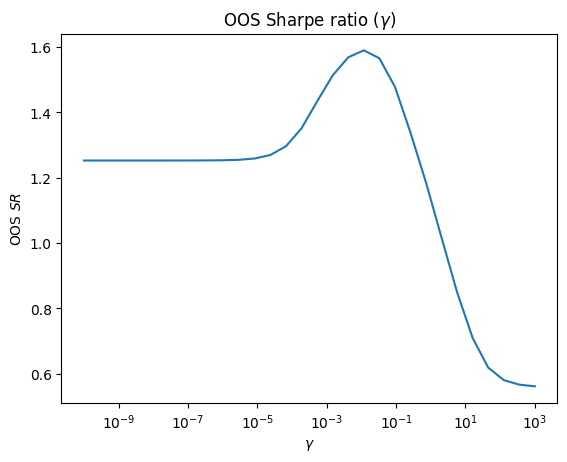

In [116]:
plot_SR(gammas, SR_rolling, path_figures + "oos_sr_rolling_128.png")

In [135]:
np.mean(R_P_rolling_max[-50:]) / np.std(R_P_rolling_max[-50:]) * np.sqrt(12)

0.9278875468667276

In [107]:
np.max(SR_rolling)

1.5896894402228818

In [277]:
# Compute return (excess + risk free) and save it in a Series
index_rolling_oos = pd.to_datetime(dates_list[rolling_window_size:])
R_P_rolling_max_df = pd.Series(R_P_rolling_max, index = index_rolling_oos)
R_P_rolling_max_tot = R_P_rolling_max_df + risk_free[index_rolling_oos]

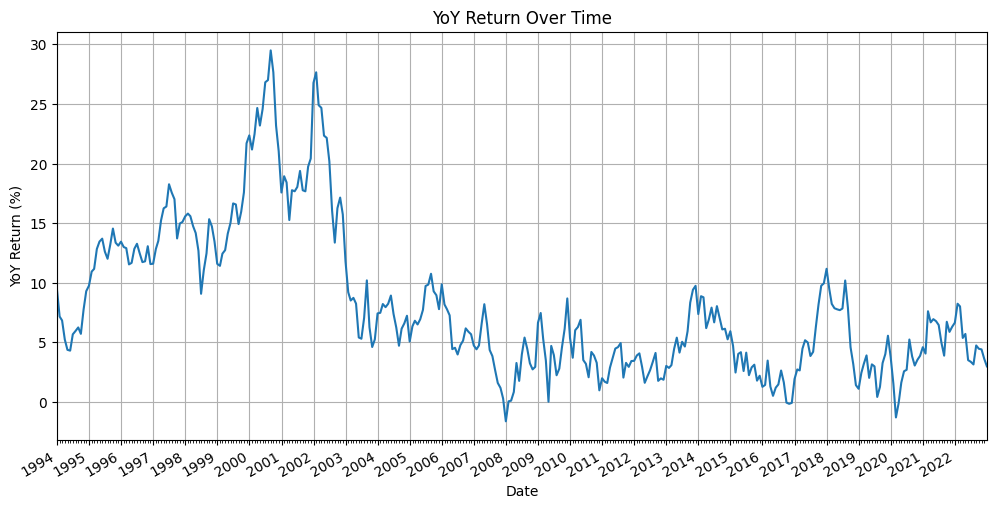

In [279]:
rolling_yoy_ret = plot_yoy_return_over_time(R_P_rolling_max_tot,path_figures + "rolling_128_yoy_ret.png")

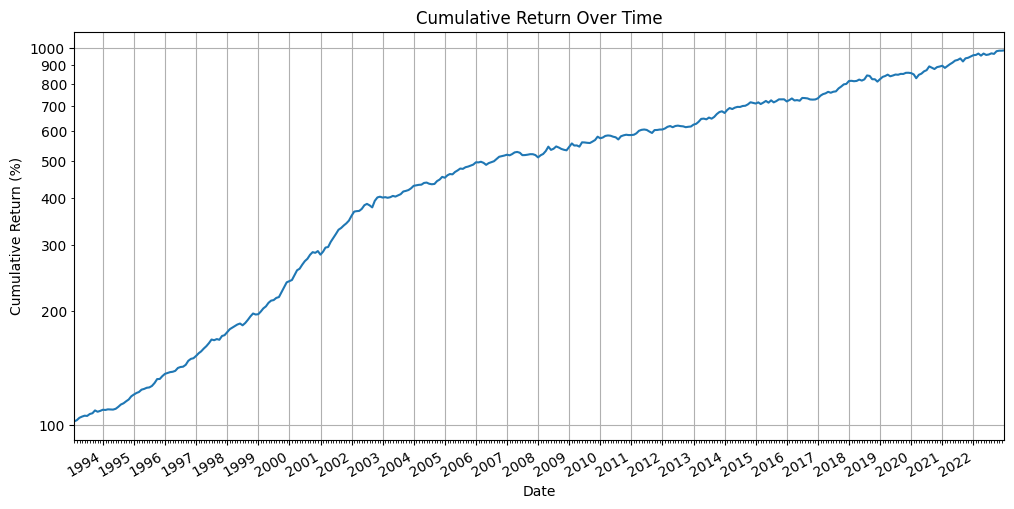

1993-01-31    102.038690
1993-02-28    102.737758
1993-03-31    104.250019
1993-04-30    105.005680
1993-05-31    105.592471
                 ...    
2022-08-31    962.507849
2022-09-30    978.329448
2022-10-31    981.411848
2022-11-30    981.505348
2022-12-31    983.183619
Length: 360, dtype: float64

In [280]:
rolling_cumulative_ret = plot_cumulative_return(R_P_rolling_max_tot,path_figures + "rolling_128_cum_ret.png")
rolling_cumulative_ret

In [281]:
res_table_rolling_capm = calculate_alpha_beta(R_P_rolling_max_df,mkt, path_figures + "summary_rolling_capm.csv")

Monthly Alpha: 2.06%
Monthly Alpha standard error: 0.24%
Annualized Alpha: 24.71%
Annualized Alpha standard error: 2.86%
Z-score: 8.6315
Beta: -0.02
Beta standard error: 0.0528
Standard Deviation of Residuals: 4.46%


In [282]:
res_table_rolling_ff = calculate_fama_french_alpha_beta(R_P_rolling_max_df,mkt,fama_french, path_figures + "summary_rolling_ff.csv")

Monthly Alpha: 2.08%
Monthly Alpha SE: 0.25%
Annualized Alpha: 24.91%
Annualized Alpha standard error: 3.00%
Z-score: 8.2986
Betas:
  mktrf: -0.0242
  smb: 0.0058
  hml: -0.0132
  rmw: -0.0389
  cma: 0.0150
Standard Deviation of Residuals: 4.46%


## Different number of factors

In [108]:
SR_OOS_all, Norm_all = different_number_factors_SDF(F, W, dates_list, rolling_window_size, d, multipliers, results,char_cols, activation, normalize, gammas, xi)

Finished processing multiplier: 0.125
Finished processing multiplier: 0.25
Finished processing multiplier: 0.5
Finished processing multiplier: 1
Finished processing multiplier: 2
Finished processing multiplier: 4
Finished processing multiplier: 8
Finished processing multiplier: 16
Finished processing multiplier: 32
Finished processing multiplier: 64
Finished processing multiplier: 128


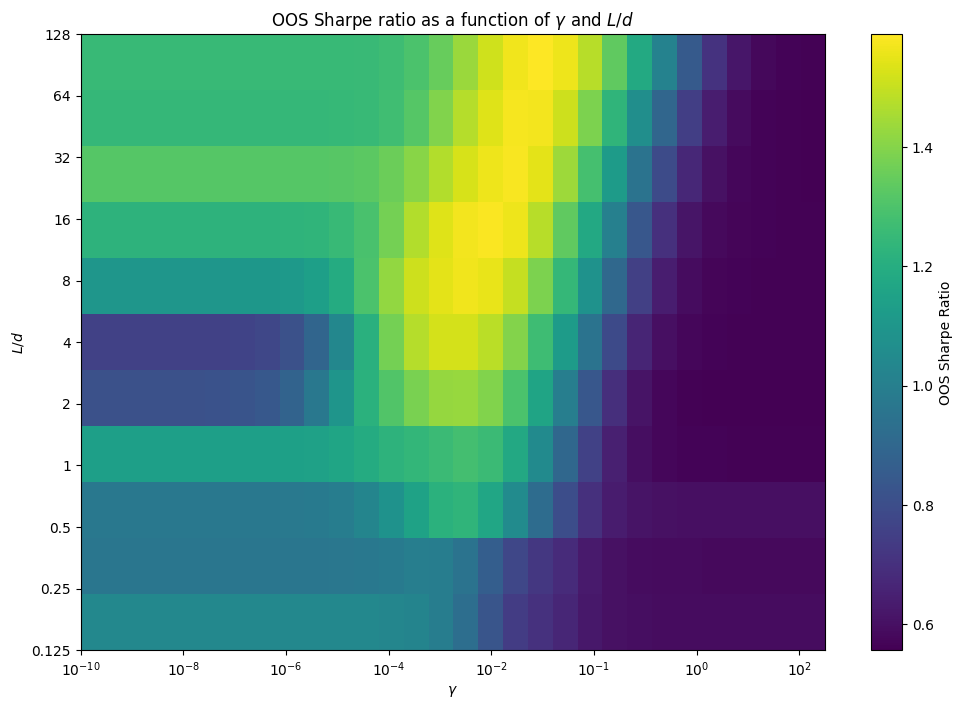

In [117]:
plot_different_number_factors(SR_OOS_all, gammas, multipliers,path_figures + "oos_sr_rolling_128_gamma_Ld.png")

In [111]:
np.max(SR_OOS_all)

1.5896894402228818

## Cross Validation

In [112]:
R_P_OOS_cv, SR_OOS_cv, optimal_gammas = rolling_cv_SDF(F, W, dates_list, rolling_window_size, gammas, results,char_cols, activation, normalize, k_folds = 5, xi = xi)

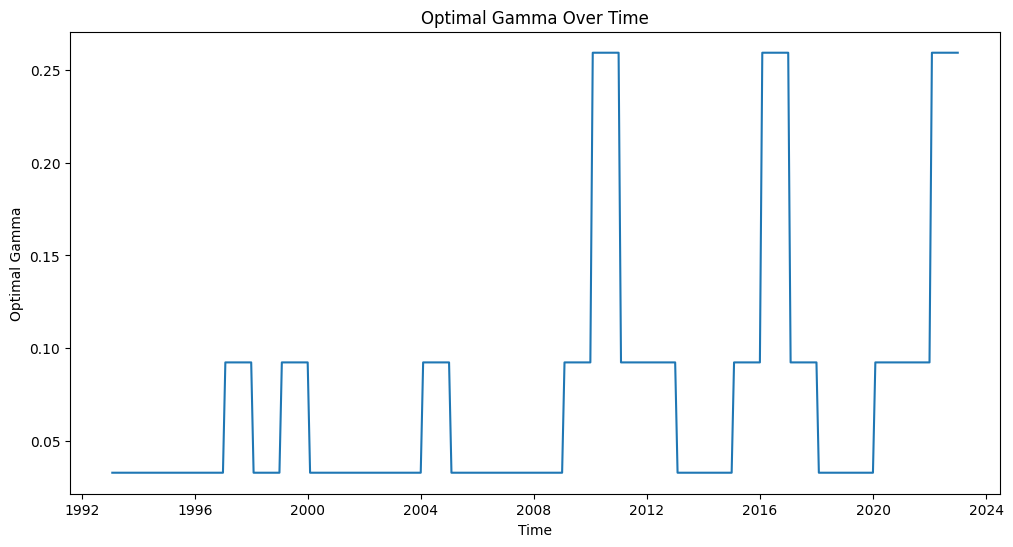

OOS Sharpe ratio:  1.4525976398923615


In [284]:
# Plot the optimal gammas over time
plt.figure(figsize=(12, 6))
plt.plot(index_rolling_oos, optimal_gammas)
plt.xlabel('Time')
plt.ylabel('Optimal Gamma')
plt.title('Optimal Gamma Over Time')
plt.savefig(path_figures + "cv_128_gamma.png", format='png', dpi=300)
plt.show()

print("OOS Sharpe ratio: ", SR_OOS_cv)

In [285]:
# Compute return (excess + risk free) and save it in a Series
R_P_OOS_cv_df = pd.Series(R_P_OOS_cv, index = index_rolling_oos)
R_P_OOS_cv_tot = R_P_OOS_cv_df + risk_free[index_rolling_oos]

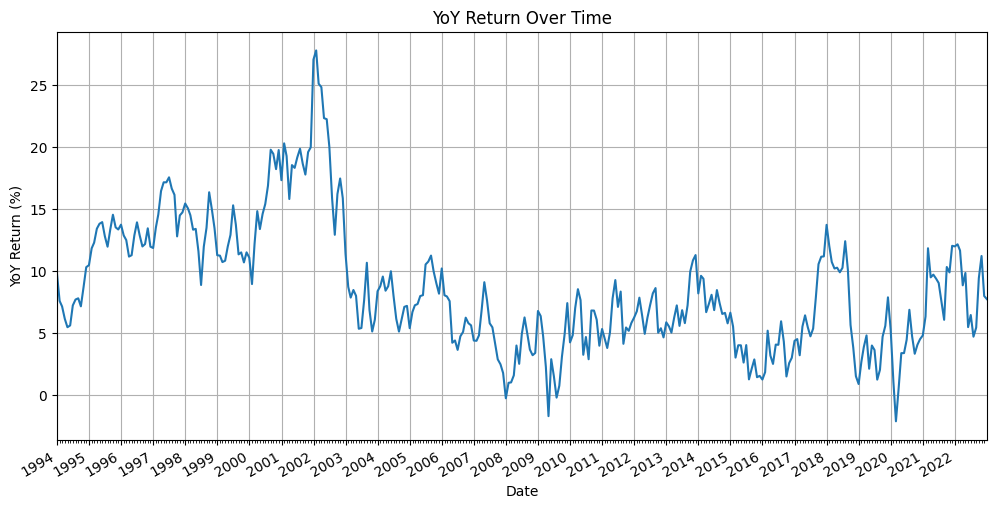

In [286]:
cv_yoy_ret = plot_yoy_return_over_time(R_P_OOS_cv_tot, path_figures + "cv_128_yoy_ret.png")

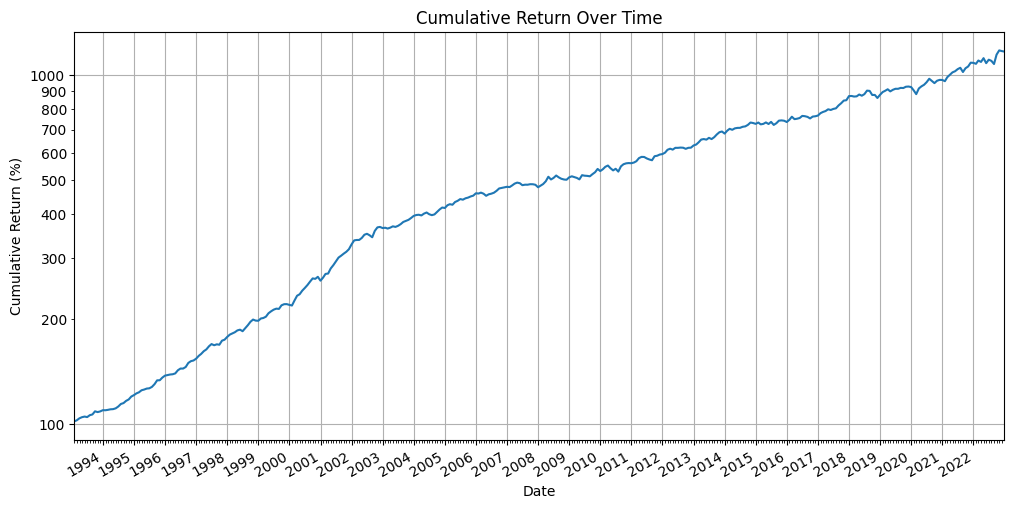

1993-01-31     102.054328
1993-02-28     102.736319
1993-03-31     104.085935
1993-04-30     104.866862
1993-05-31     105.289230
                 ...     
2022-08-31    1078.440568
2022-09-30    1147.332804
2022-10-31    1179.853544
2022-11-30    1174.528543
2022-12-31    1170.646494
Length: 360, dtype: float64

In [288]:
cv_cumulative_ret = plot_cumulative_return(R_P_OOS_cv_tot, path_figures + "cv_128_cum_ret.png")
cv_cumulative_ret

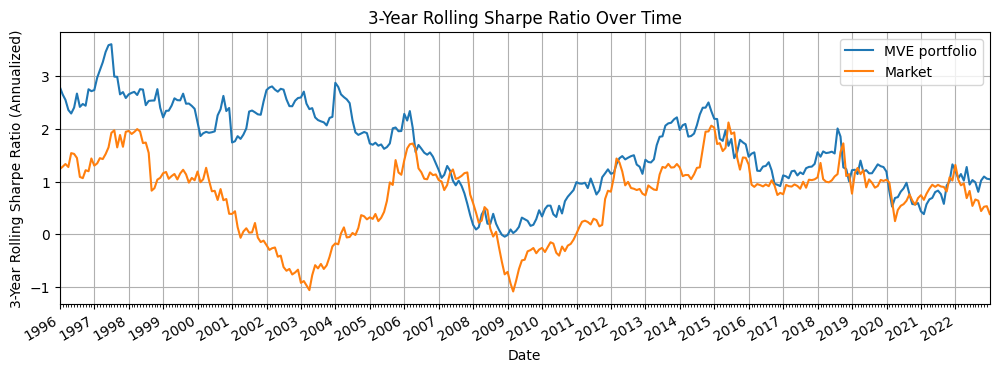

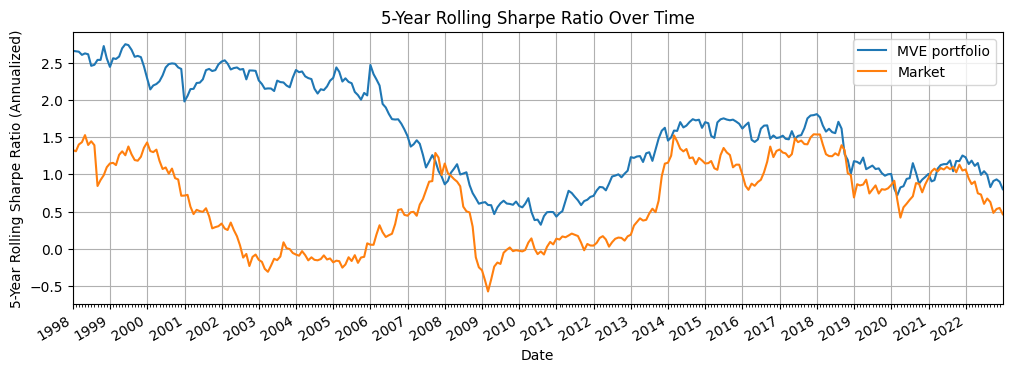

In [297]:
n_years = 3
rolling_cv_sr_3 = plot_rolling_sharpe_ratio(R_P_OOS_cv_df,n_years, path_figures + f"{n_years}yr_rolling_sr.png",mkt)
n_years = 5
rolling_cv_sr_5 = plot_rolling_sharpe_ratio(R_P_OOS_cv_df,n_years, path_figures + f"{n_years}yr_rolling_sr.png",mkt)

In [290]:
res_table_cv_capm = calculate_alpha_beta(R_P_OOS_cv_df,mkt,path_figures + "summary_cv_capm.csv")

Monthly Alpha: 1.93%
Monthly Alpha standard error: 0.24%
Annualized Alpha: 23.13%
Annualized Alpha standard error: 2.85%
Z-score: 8.1069
Beta: -0.08
Beta standard error: 0.0527
Standard Deviation of Residuals: 4.45%


In [291]:
res_table_cv_ff = calculate_fama_french_alpha_beta(R_P_OOS_cv_df,mkt,fama_french, path_figures + "summary_cv_ff.csv")

Monthly Alpha: 1.92%
Monthly Alpha SE: 0.25%
Annualized Alpha: 23.06%
Annualized Alpha standard error: 2.99%
Z-score: 7.7066
Betas:
  mktrf: -0.0801
  smb: 0.0033
  hml: -0.0143
  rmw: 0.0209
  cma: -0.0026
Standard Deviation of Residuals: 4.45%


## Convergence rate analysis

In [292]:
# define rolling window sizes and respective number of features.
Ts = 12 * np.arange(1,31)
print(Ts)
Ls= np.floor(1000/np.sqrt(360)*np.sqrt(Ts)).astype(int)
print(Ls)

[ 12  24  36  48  60  72  84  96 108 120 132 144 156 168 180 192 204 216
 228 240 252 264 276 288 300 312 324 336 348 360]
[ 182  258  316  365  408  447  483  516  547  577  605  632  658  683
  707  730  752  774  795  816  836  856  875  894  912  930  948  966
  983 1000]


In [293]:
SR_OOS_all, Norm_all = convergence_SDF(F, W, dates_list, rolling_window_size, Ts, Ls, results,char_cols, activation, normalize, gammas, xi)

Finished processing model with:  182  factors.
Finished processing model with:  258  factors.
Finished processing model with:  316  factors.
Finished processing model with:  365  factors.
Finished processing model with:  408  factors.
Finished processing model with:  447  factors.
Finished processing model with:  483  factors.
Finished processing model with:  516  factors.
Finished processing model with:  547  factors.
Finished processing model with:  577  factors.
Finished processing model with:  605  factors.
Finished processing model with:  632  factors.
Finished processing model with:  658  factors.
Finished processing model with:  683  factors.
Finished processing model with:  707  factors.
Finished processing model with:  730  factors.
Finished processing model with:  752  factors.
Finished processing model with:  774  factors.
Finished processing model with:  795  factors.
Finished processing model with:  816  factors.
Finished processing model with:  836  factors.
Finished proc

In [294]:
gamma_id = np.argmax(SR_rolling)

Norms = np.sqrt(Norm_all[:, gamma_id])

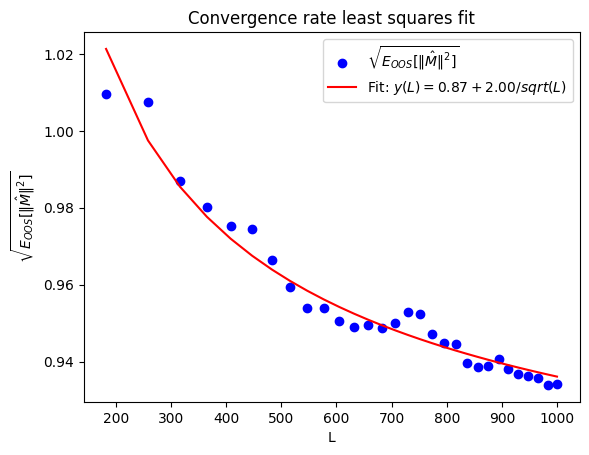

In [295]:
# Define the model function
def model(L, C1, C2):
    return C1 + C2 / np.sqrt(L)

# Define the objective function (sum of squared residuals)
def objective(params, Ls, Norms):
    C1, C2 = params
    return np.sum((Norms - model(Ls, C1, C2))**2)

# Initial guess for C1 and C2
initial_guess = [1, 1]

# Perform the minimization
result = minimize(objective, initial_guess, args=(Ls, Norms))

# Extract the optimized parameters
C1_opt, C2_opt = result.x

# Generate y values using the fitted model
fitted_values = model(Ls, C1_opt, C2_opt)

# Plot the original data
plt.scatter(Ls, Norms, label='$\sqrt{E_{OOS}[\|\hat{M}\|^2]}$', color='blue')

# Plot the fitted curve
plt.plot(Ls, fitted_values, label=f'Fit: $y(L) = {C1_opt:.2f} + {C2_opt:.2f}/sqrt(L)$', color='red')

# Add labels and title
plt.xlabel('L')
plt.ylabel('$\sqrt{E_{OOS}[\|\hat{M}\|^2]}$')
plt.title('Convergence rate least squares fit')
plt.legend()
plt.savefig(path_figures+"convergence.png", format='png', dpi=300)
# Show the plot
plt.show()